整理自  https://github.com/ZhiqingXiao/rl-book/blob/master/en2024/code/Acrobot-v1_PPO_torch.ipynb

* <mark>没用 λ</mark>


环境： https://gymnasium.farama.org/environments/classic_control/acrobot/

* gymnasium.make("Acrobot-v1")

 离散

 目标是让自由端在尽可能少的步骤中到达指定的目标高度，因此所有未达到目标的步骤都会产生 -1 奖励。达到目标高度将导致终止，奖励为 0。奖励阈值为 -100。

 回合长度阈值 为 500。

# Code

In [ ]:
!pip install gymnasium

In [ ]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
torch.manual_seed(0)

import gymnasium as gym

logging.basicConfig(level=logging.INFO,
          format='%(asctime)s [%(levelname)s] % (message)s',
          stream=sys.stdout, datefmt='%H:%M:%S')


# import warnings   # 忽略警告
# warnings.filterwarnings("ignore")

## 代码模块

In [ ]:
class PPOReplayer:
  def __init__(self):
    self.fields = ['state', 'action', 'prob', 'advantage', 'return']  # 字段
    self.memory = pd.DataFrame(columns=self.fields)

  def store(self, df):
    self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)

  def sample(self, size):
    indices = np.random.choice(self.memory.shape[0], size=size)
    return (np.stack(self.memory.loc[indices, field]) for field in self.fields)

In [ ]:
class PPOAgent:
  def __init__(self, env):
    self.gamma = 0.99
    self.replayer = PPOReplayer()

    # 策略 的神经网络 θ
    self.actor_net = self.build_net(
                      input_size = env.observation_space.shape[0],
                      hidden_sizes = [100,],
                      output_size = env.action_space.n, output_activator=nn.Softmax(1) )
    self.actor_optimizer = optim.Adam(self.actor_net.parameters(), 0.001)

    # 价值函数 的 神经网络 ф
    self.critic_net = self.build_net(
                      input_size=env.observation_space.shape[0],
                      hidden_sizes=[100,]   )
    self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.002)
    self.critic_loss = nn.MSELoss()

  def build_net(self, input_size, hidden_sizes, output_size=1, output_activator=None):
    layers = []
    for input_size, output_size in zip([input_size,] + hidden_sizes, hidden_sizes + [output_size, ]):
      layers.append(nn.Linear(input_size, output_size))
      layers.append(nn.ReLU())
    layers = layers[:-1]  # 去掉最后一层
    if output_activator:
      layers.append(output_activator)
    net = nn.Sequential(*layers)
    return net

  def reset(self, mode=None):
    self.mode = mode
    if self.mode == 'train':
      self.trajectory = []

  def step(self, observation, reward, terminated):
    state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
    prob_tensor = self.actor_net(state_tensor)
    action_tensor = distributions.Categorical(prob_tensor).sample()
    action = action_tensor.numpy()[0]
    # 上面 3 行代码 等效于 action = distributions.Categorical(prob_tensor).sample().item()
    if self.mode == 'train':
      self.trajectory += [observation, reward, terminated, action]
    return action

  def close(self):
    if self.mode == "train":
      self.save_trajectory_to_replayer()
      if len(self.replayer.memory) >= 1000:  # T = 1000
        for batch in range(5): # N = 5
          self.learn()
        self.replayer = PPOReplayer()

  def save_trajectory_to_replayer(self):
    df = pd.DataFrame(np.array(self.trajectory, dtype=object).reshape(-1, 4),
              columns=['state', 'reward', 'terminated', 'action'])
    state_tensor = torch.as_tensor(np.stack(df['state']), dtype=torch.float)
    action_tensor = torch.as_tensor(df['action'], dtype=torch.long)
    v_tensor = self.critic_net(state_tensor)
    df['v'] = v_tensor.detach().numpy()
    prob_tensor = self.actor_net(state_tensor)
    pi_tensor = prob_tensor.gather(-1, action_tensor.unsqueeze(1)).squeeze(1)
    df['prob'] = pi_tensor.detach().numpy()
    df['next_v'] = df['v'].shift(-1).fillna(0.) # 整列上移一位
    df['u'] = df['reward'] + self.gamma * df['next_v'] # r_t + γ V(s_{t+1})
    df['delta'] = df['u'] - df['v'] # Δt = r_t + γ V(s_{t+1}) - V(s_t)
    df['advantage'] = signal.lfilter([1.,], [1., -self.gamma], df['delta'][::-1])[::-1] # 参考下面的 单元格
    df['return'] = signal.lfilter([1.,],[1.,-self.gamma], df['reward'][::-1])[::-1]
    self.replayer.store(df)

  def learn(self):
    states, actions, old_pis, advantages, returns = self.replayer.sample(size=64)
    state_tensor = torch.as_tensor(states, dtype=torch.float)
    action_tensor = torch.as_tensor(actions, dtype=torch.long)
    old_pi_tensor = torch.as_tensor(old_pis, dtype=torch.float)
    advantage_tensor = torch.as_tensor(advantages, dtype=torch.float)
    return_tensor = torch.as_tensor(returns, dtype=torch.float).unsqueeze(1)

    # 更新 actor
    all_pi_tensor = self.actor_net(state_tensor)
    pi_tensor = all_pi_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
    surrogate_advantage_tensor = (pi_tensor / old_pi_tensor) * advantage_tensor
    clip_times_advantage_tensor = 0.1 * surrogate_advantage_tensor # ε= 0.1
    max_surrogate_advantage_tensor = advantage_tensor + torch.where(advantage_tensor > 0., clip_times_advantage_tensor, -clip_times_advantage_tensor)
    # 上行代码： 当 A > 0,  g(ε,A) = A + εA ; 否则 g(ε,A) = A - εA
    clipped_surrogate_advantage_tensor = torch.min(surrogate_advantage_tensor, max_surrogate_advantage_tensor) # min()

    actor_loss_tensor = -clipped_surrogate_advantage_tensor.mean()
    self.actor_optimizer.zero_grad()
    actor_loss_tensor.backward() # 反向传播 梯度
    self.actor_optimizer.step()

    # 更新 critic
    pred_tensor = self.critic_net(state_tensor)
    critic_loss_tensor = self.critic_loss(pred_tensor, return_tensor)
    self.critic_optimizer.zero_grad()
    critic_loss_tensor.backward()
    self.critic_optimizer.step()

In [ ]:
# https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ppo/core.py

# def discount_cumsum(x, discount):
#     """
#     magic from rllab for computing discounted cumulative sums of vectors.

#     input:
#         vector x,
#         [x0,
#          x1,
#          x2]

#     output:
#         [x0 + discount * x1 + discount^2 * x2,
#          x1 + discount * x2,
#          x2]
#     """
#     return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

### 环境

In [ ]:
# Create and wrap the environment
env = gym.make("Acrobot-v1")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward


agent = PPOAgent(env)

## 训练

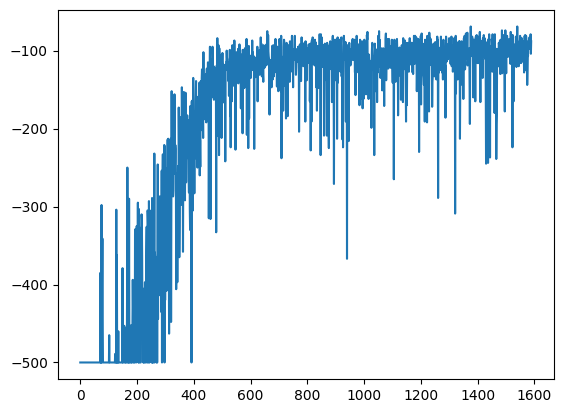

In [ ]:
def play_episode(env, agent, seed=None, mode=None, render=False):
  obs, info = wrapped_env.reset(seed=2024)  # 这个可以固定种子
  reward, done = 0., False
  agent.reset(mode=mode)
  episode_reward, elapsed_steps = 0., 0
  while not done:
      action = agent.step(obs, reward, done)
      obs, reward, terminated, truncated, info = wrapped_env.step(action)
      done = terminated or truncated

      episode_reward += reward
      elapsed_steps += 1
  agent.close()
  return episode_reward, elapsed_steps

logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode, mode='train') # seed = episode
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-100:]) >= -100:
        break
plt.plot(episode_rewards)

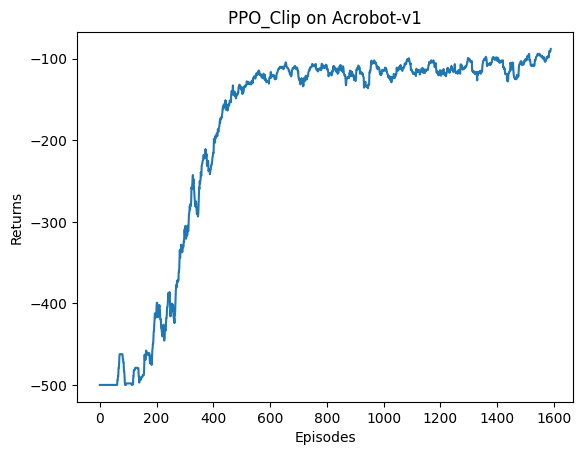

In [ ]:
# 平滑

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

mv_return = moving_average(episode_rewards, 19)  # 9 可考虑改大些，让图好看些
episodes_list = list(range(len(episode_rewards)))
# plt.plot(episodes_list, mv_return)  # x y
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO_Clip on {}'.format('Acrobot-v1'))
plt.plot(episodes_list, mv_return)  # x y

In [ ]:
logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [ ]:
env.close()

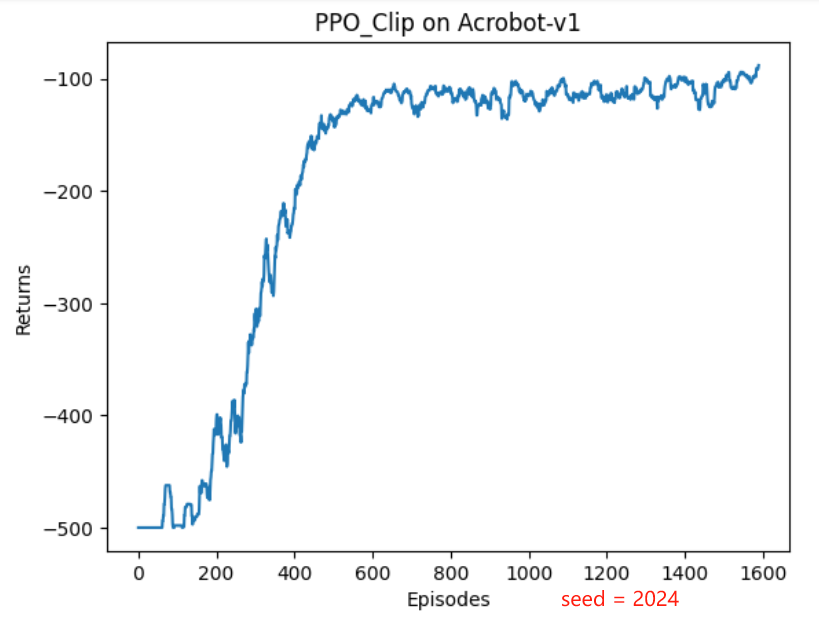

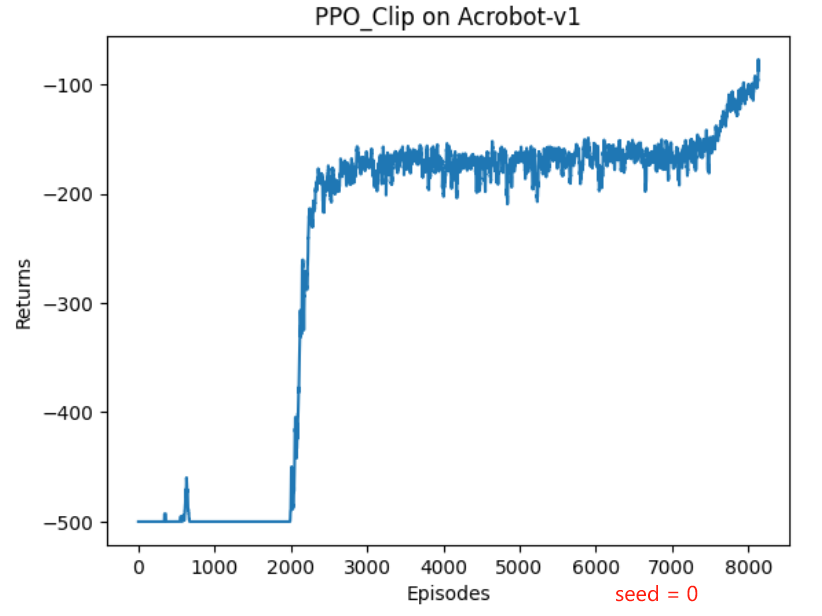

### seed 实验

耗时较长 ！！！

In [ ]:
import random

# Create and wrap the environment
env_name = "Acrobot-v1"
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
# # deque_size – The size of the buffers return_queue and length_queue  本代码中 打印的回报均值 为 50 个回合的均值

total_num_episodes = int(5e3)  # Total number of episodes  5000

rewards_over_seeds = []

for seed in [0, 2024, 5]:  # seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed) # 这个似乎对结果没影响
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = PPOAgent(env)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)
        reward, done = 0., False
        agent.reset(mode='train')
        episode_reward, elapsed_steps = 0., 0
        while not done:
            action = agent.step(obs, reward, done)
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            done = terminated or truncated

            episode_reward += reward
            elapsed_steps += 1
        agent.close()

        reward_over_episodes.append(wrapped_env.return_queue[-1])

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

Episode: 0 Average Reward: -500
Episode: 1000 Average Reward: -500
Episode: 2000 Average Reward: -499
Episode: 3000 Average Reward: -170
Episode: 4000 Average Reward: -177
Episode: 0 Average Reward: -168
Episode: 1000 Average Reward: -140
Episode: 2000 Average Reward: -103
Episode: 3000 Average Reward: -88
Episode: 4000 Average Reward: -94
Episode: 0 Average Reward: -93
Episode: 1000 Average Reward: -122
Episode: 2000 Average Reward: -108
Episode: 3000 Average Reward: -93
Episode: 4000 Average Reward: -96


[Text(0.5, 1.0, 'PPO-Clip for Acrobot-v1')]

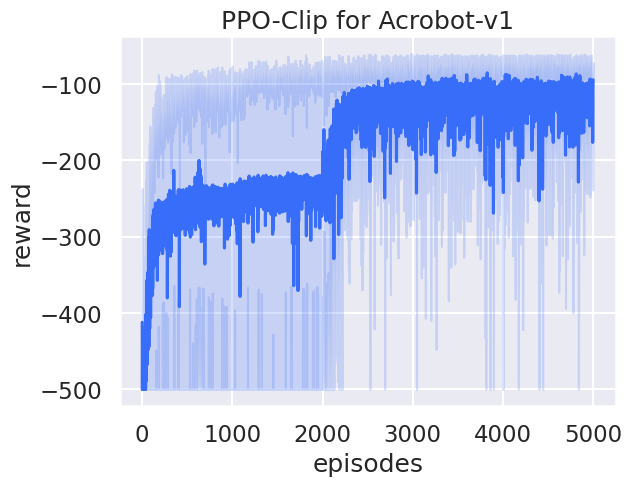

In [ ]:
import pandas as pd
import seaborn as sns

rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]

df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="PPO-Clip for {}".format(env_name)
)

[Text(0.5, 1.0, 'PPO-Clip for Acrobot-v1')]

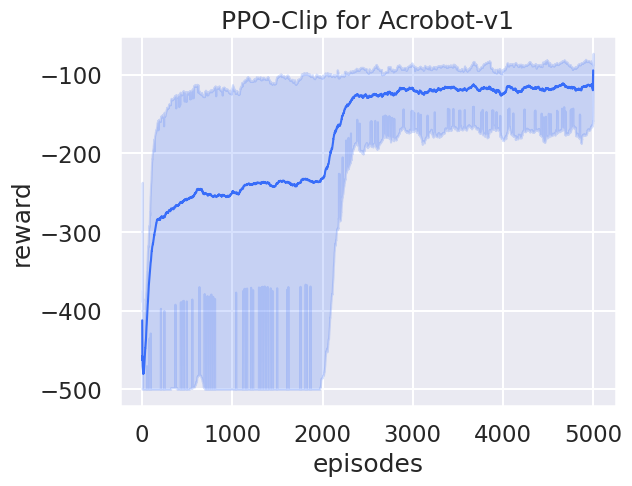

In [ ]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
# print(rewards_to_plot)
for i in range(len(rewards_to_plot)):
  rewards_to_plot[i] = moving_average(rewards_to_plot[i], 69) # 调这里 更改平滑度

# rewards_to_plot = [[reward[0] for reward in np.array(moving_average(rewards, window_size=29))] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()  #  .rolling(window=30).mean()

df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1, linewidth=1.5).set(
    title="PPO-Clip for {}".format(env_name)
)   # 调线宽